# Book Cover Color Exploration

In [1]:
import urllib
import PIL
from PIL import Image
from io import BytesIO
import requests
import numpy as np
import pandas as pd
from matplotlib import image
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import turicreate as tc
import turicreate.aggregate as agg
from turicreate.toolkits.recommender.util import precision_recall_by_user
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA as sklearnPCA

In [2]:
np.random.seed(0)

# BOOK COVER COLOR CLUSTERING

### Step 1: Extract and save pixel arrays from book cover image URLs

In [9]:
# Read in book data set

# bk = pd.read_csv('../data/raw_data/books.csv')

In [ ]:
# Remove books with no image

# bk_scrub = bk.iloc[[i for i in range(len(bk)) if 'nophoto' not in bk['image_url'][i]],:]
# bk_scrub = bk_scrub.reset_index()

In [ ]:
# Initialize lists to store pixel RGB values for different size images

# px100 = []
# px28 = []

In [ ]:
# Get pixel values for 100x100 and 28x28 versions of all book covers

# for i in range(6668):
#     url = bk_scrub['image_url'][i]
#     response = urllib.request.urlopen(url)
#     img = Image.open(BytesIO(response.read()))
#     response = requests.get(url)
#     img = Image.open(BytesIO(response.content))
#     img = img.convert('RGB')
    
#     img = img.resize((100,100),Image.ANTIALIAS)
#     px100.append(np.array(img))
#     img = img.resize((28,28),Image.ANTIALIAS)
#     px28.append(np.array(img))

In [ ]:
# Add pixel values to data frame, create pixel arrays with each value rounded to the nearest 20 to reduce combos,
# Save as a pickle file to maintain the array format for pixel data

# bk_scrub['px100'] = px100
# bk_scrub['px28'] = px28
# px100_rd = list(np.multiply(np.floor(np.divide(px100,20)),20).astype(int))
# px28_rd = list(np.multiply(np.floor(np.divide(px28,20)),20).astype(int))
# bk_scrub['px100_rd'] = px100_rd
# bk_scrub['px28_rd'] = px28_rd
# bk_scrub.to_pickle('books_px.pickle')

In [8]:
# read the pickle file back in as a new data frame

bkpx = pd.read_pickle('../data/books_px.pickle')

### Step 2: Cluster all RGB combinations into different colors

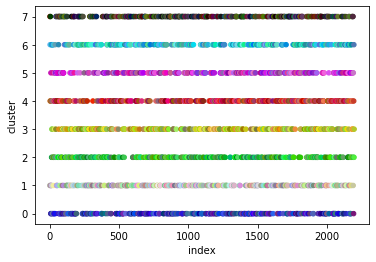

In [10]:
# Cluster all possible RGB combinations when rounding to the nearest 20

px_val = [a*20 for a in range(13)]
px_val_resize = [a/255.0 for a in px_val]
px_combos = [(a,b,c) for a in px_val_resize for b in px_val_resize for c in px_val_resize]

## fit model 
km = KMeans (n_clusters=8, init='k-means++', random_state=10) 
km.fit(px_combos)

## predict and graph color clusters
preds = km.predict(px_combos)
px_df = pd.DataFrame([px_combos, preds]).T
px_df = px_df.rename({0: 'rgb', 1:'cluster'}, axis='columns')
px_df = px_df.sample(frac=1).reset_index()
colors = px_df.rgb
px_df.drop(['index'], axis=1).reset_index().plot(x='index', y='cluster', kind='scatter', color=colors)

### Step 3: Assign color values to each book cover pixel and calculate percentage of each color per image

In [12]:
# Name the color clusters and save a DataFrame of all RGB values corresponding to their colors

colors_dict = {7: 'dark', 6:'cyan', 5:'magenta', 4:'red', 3:'yellow', 2:'green', 1:'light', 0:'blue'}
px = [(a,b,c) for a in px_val for b in px_val for c in px_val]
df = pd.DataFrame([px, preds]).T
df.columns = ['rgb', 'cluster']
df['color'] = [colors_dict[i] for i in preds]
df['rgb_list'] = np.array(df['rgb'])
df = df.set_index(['rgb_list'])


In [13]:
# Map each pixel to its color (takes time)

color28 = []
for i in range(6668):
    color28.append([df['color'][tuple(a)] for a in bkpx['px28_rd'][i].reshape((784,3))])
    

In [14]:
# Save the color arrays

bkpx['color28'] = color28

In [15]:
# Calculate percentage of each color in the book cover images 

pct_blue = []
pct_light = []
pct_green = []
pct_yellow = []
pct_red = []
pct_magenta = []
pct_cyan = []
pct_dark = []

for i in color28:
    pct_blue.append(i.count('blue')/784)
    pct_light.append(i.count('light')/784)
    pct_green.append(i.count('green')/784)
    pct_yellow.append(i.count('yellow')/784)
    pct_red.append(i.count('red')/784)
    pct_magenta.append(i.count('magenta')/784)
    pct_cyan.append(i.count('cyan')/784)
    pct_dark.append(i.count('dark')/784)

### Step 4: Fit a K Means clustering model on the book covers and print out clusters

In [16]:
# Create data frame for fitting the model with features corresponding to each color percentage

X = pd.DataFrame({'pct_blue': pct_blue,
                 'pct_light': pct_light, 'pct_green': pct_green, 'pct_yellow': pct_yellow, 
                 'pct_red': pct_red, 'pct_magenta': pct_magenta, 'pct_cyan': pct_cyan,
                 'pct_dark': pct_dark})

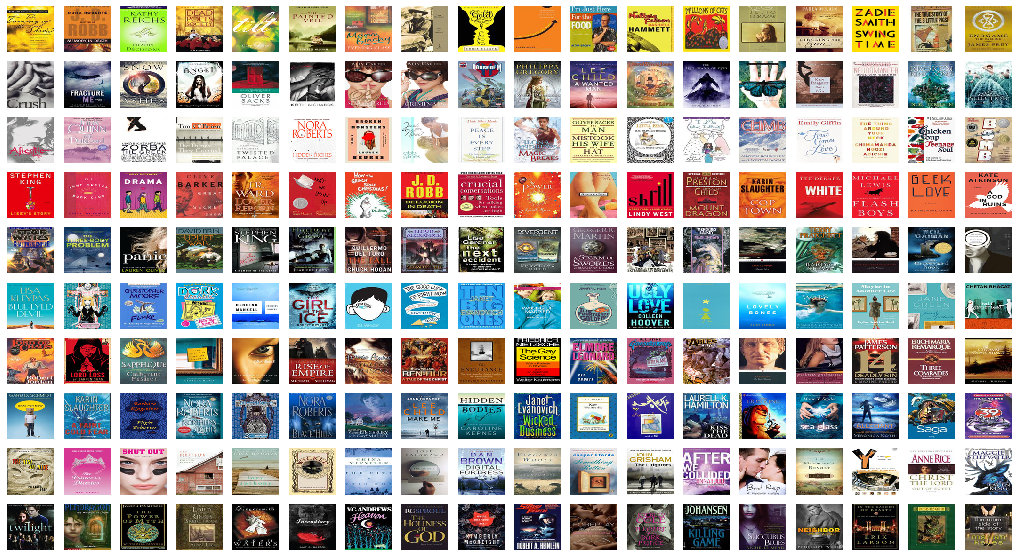

In [19]:
# Define a function to cluster and print out book covers with varying number of clusters

def book_cluster(k, examples):
    model = KMeans (n_clusters=k, init='k-means++', random_state=10)
    model.fit(X)
    bkpx['cluster'] = model.predict(X)

    fig, axes = plt.subplots(k,examples, figsize=(examples,k))

    arr=[]
    rs = bkpx.sample(frac=1)
    rs = rs.reset_index()
    for j in range(k):
        arr = np.append(arr, np.where(rs['cluster'] == j)[0][0:examples])

    i=0
    for ax in axes.flat:
        # remove tick marks and axes for clearer plots
        ax.axis('off')
        ax.imshow(rs['px100'][int(arr[i])])
        i+=1
        if i==k*examples:
             break
                
book_cluster(10, 18)

# VISUALIZE CLUSTERS

https://towardsdatascience.com/t-sne-python-example-1ded9953f26

## tSNE

In [141]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
tsne = TSNE()
X_embedded = tsne.fit_transform(color_pct_matrix)
y = list(bk_plus_color['cluster'])

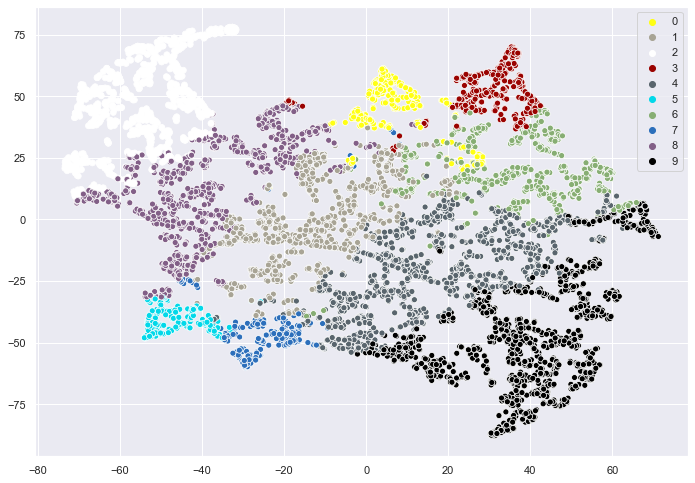

In [142]:
colors = ["yellow", "greyish", "white", "deep red", "slate grey", 
          "aqua blue", "sage", "medium blue", "dusty purple", "black"]
palette = sns.xkcd_palette(colors)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue =y, legend='full', palette=palette)

## PCA

In [238]:

sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)


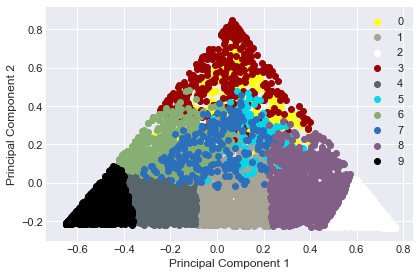

In [283]:
cluster = np.array(bkpx['cluster'])

with plt.style.context('seaborn-darkgrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip((0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
                        ("#ffff14", '#a8a495', "#ffffff", "#9a0200", "#59656d", "#02d8e9", "#87ae73", "#2c6fbb", "#825f87", "#000000")):
        plt.scatter(Y_sklearn[cluster==lab, 0],
                    Y_sklearn[cluster==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# RECOMMENDER BY COLOR

In [ ]:
# bk_plus_color = pd.concat([bkpx,X], axis=1)

# bk_plus_color.to_csv('../data/books_colors.csv')

In [77]:
# CODE FOR RECOMMENDER DEMO

# Read in csv file with books and colors
bk_plus_color = pd.read_csv('../data/books_colors.csv')

# Distance Matrix
cosine_sim_colors = cosine_similarity(
    bk_plus_color[['pct_blue', 'pct_light', 'pct_green', 'pct_yellow', 'pct_red', 'pct_magenta', 'pct_cyan', 'pct_dark']],
    bk_plus_color[['pct_blue', 'pct_light', 'pct_green', 'pct_yellow', 'pct_red', 'pct_magenta', 'pct_cyan', 'pct_dark']])
  
    
    
    # All the books 
titles = bk_plus_color['title']
indices = pd.Series(bk_plus_color.index, index=bk_plus_color['title'])


def similarity_by_colors(book, dist_matrix, num_recs=10):
    
    try:

        index = indices[book]
        scores = list(enumerate(dist_matrix[index]))
        scores = sorted(scores, key=lambda x: x[1], reverse=True)

        if num_recs > len(scores):
            scores = scores[1:len(scores)]  
        else:
            scores = scores[1:num_recs+1]            

        book_indices = [book[0] for book in scores]

        return titles.iloc[book_indices]

    except:
        print("We don't have that book!")

In [85]:
# All the books 
bk_plus_color = pd.concat([bkpx,X], axis=1)

titles = bk_plus_color['title']
indices = pd.Series(bk_plus_color.index, index=bk_plus_color['title'])

cosine_sim_colors = cosine_similarity(
    bk_plus_color[['pct_blue', 'pct_light', 'pct_green', 'pct_yellow', 'pct_red', 'pct_magenta', 'pct_cyan', 'pct_dark']],
    bk_plus_color[['pct_blue', 'pct_light', 'pct_green', 'pct_yellow', 'pct_red', 'pct_magenta', 'pct_cyan', 'pct_dark']])
  

# Book Recs based on the cosine similarity score of colors in the book cover
def print_similar_books(book, dist_matrix, num_recs=10):
    try:

        #Find the index of the book
        index = indices[book]
    #         print(index)
        print()

        #Using that index get the list of cosine similarities (list of 8730)
        # Each entry looks like >> (1135, 1.0)
        #                          (index in dataframe, similarity score)
        scores = list(enumerate(dist_matrix[index]))

        #Order that list by cosine similaritie and get the indexes of the rows that are similar
        scores = sorted(scores, key=lambda x: x[1], reverse=True)

        # If you are asking for more recs than we even have books for that author
        # then give you all the books for that author
        if num_recs > len(scores):
            scores = scores[1:len(scores)]  
        else:
            #Give you number of recs you want
            scores = scores[1:num_recs+1]            

        print(scores)
        print()

        #Iterate and get all the indexes that we want to recommend
        book_indices = [book[0] for book in scores]

        print(book_indices)



        fig, axes = plt.subplots(1,num_recs, figsize=(num_recs*2,1*2))

        ax = 0
        for i in book_indices:
            # remove tick marks and axes for clearer plots
            axes.flat[ax].axis('off')
            axes.flat[ax].imshow(bk_plus_color['px100'][i])
            ax+=1


#             Pull list of books using those indexes!
        return titles.iloc[book_indices]

    except:
        print("We don't have that book!")

### Test Recommender

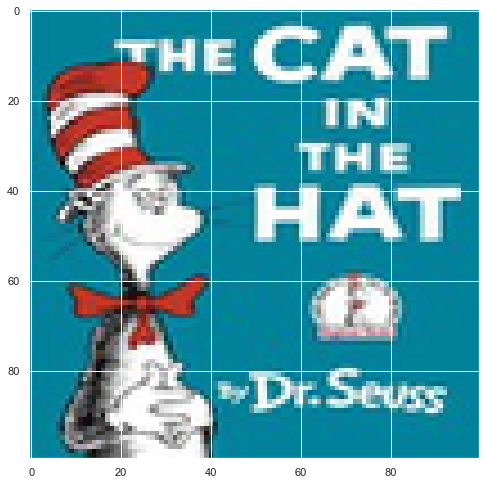

In [157]:
def print_book(book):
    arr = np.where(bk_plus_color['title'] == book)[0]
    plt.imshow(bk_plus_color['px100'][int(arr)])
    
print_book(book)


[(255, 0.9964276274622565), (886, 0.9962783989460221), (4642, 0.9936343017712843), (1531, 0.9926405090479502), (987, 0.9895843665157142), (104, 0.9868920101972032), (4706, 0.9846082829931683), (4520, 0.981949530085936), (3002, 0.9799981757525114), (847, 0.9791461679068402)]

[255, 886, 4642, 1531, 987, 104, 4706, 4520, 3002, 847]


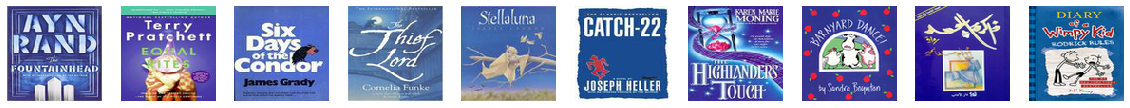

In [156]:
# test out color recommender
book ='The Cat in the Hat'

y = print_similar_books(book, cosine_sim_colors, 10)



# PREDICTING COLOR FROM TAGS

In [93]:
ub = pd.read_csv('../data/parsed_data/ultimate_books.csv')

In [280]:


def book_cluster(k):
    X = pd.DataFrame({'pct_blue': pct_blue,
                 'pct_light': pct_light, 'pct_green': pct_green, 'pct_yellow': pct_yellow, 
                 'pct_red': pct_red, 'pct_magenta': pct_magenta, 'pct_cyan': pct_cyan,
                 'pct_dark': pct_dark})
    
    model = KMeans (n_clusters=k, init='k-means++', random_state=10)
    model.fit(X)
    bkpx['cluster'] = model.predict(X)

    x = pd.merge(bkpx, ub, how='inner', left_on='book_id', right_on='book_id')
    x_train = x[:5000]
    x_test = x[5000:]

    test_data, test_labels = list(x['tag_name'])[5000:], list(x['cluster_x'])[5000:]
    train_data, train_labels = list(x['tag_name'])[:5000], list(x['cluster_x'])[:5000]

    
    
    print('{} CLUSTERS:'.format(k))
   
    
    v = TfidfVectorizer()
    X = v.fit_transform(train_data)
    X_test = v.transform(test_data)
    
    # function to print results from different classifiers in a standardized way
    def print_results(classifier, parameter, param_vals, acc, f1):
        # use the highest f1-score to determine the optimal parameter value
        print('{}: {:.2f}% ({} = {}).\n'
              .format(classifier, max(acc)*100, parameter, param_vals[acc.index(max(acc))]))
        
    # function to extract and return the accuracy and F1 scores each time a new model is fit
    def get_acc_f1(preds, acc, f1):
        correct, total = 0, 0
        for pred, label in zip(preds, test_labels):
            if pred == label: correct += 1
            total += 1
        acc.append(1.0*correct/total)
        f1.append(metrics.f1_score(test_labels, preds, average='weighted'))
        return acc, f1
    
    # function to fit KNN models with varying k values
    def build_knn(num_kvals):
        # choose a range of odd k values to test
        k = [j*2+1 for j in range(num_kvals)]
        # initialize accuracy and fl score lists
        acc = []
        f1 = []
        # fit and predict on the knn models for each k value
        for i in k:
            knn = KNeighborsClassifier(n_neighbors=i)
            knn.fit(X, train_labels)
            preds = knn.predict(X_test)
            acc, f1 = get_acc_f1(preds, acc, f1)
        optimal_k = k[acc.index(max(acc))]
        print_results('K Nearest Neighbors', 'k', k, acc, f1)
        return 'K Nearest Neighbors', 'k', optimal_k, max(acc)
    
    
    # function to fit Multinomial Naive Bayes models with varying alpha values
    def build_mnb():
        alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
        acc = []
        f1 = []
        for i in alphas:
            mnb = MultinomialNB(alpha = i)
            mnb.fit(X, train_labels)
            preds = mnb.predict(X_test)
            get_acc_f1(preds, acc, f1)
        optimal_alpha = alphas[acc.index(max(acc))]
        print_results('Multinomial Naive Bayes', 'alpha', alphas, acc, f1)
        # confusion matrix
#         print("Confusion Matrix where each row is the true category and each column is the predicted category:")
#         conf = pd.DataFrame(confusion_matrix(test_labels, preds))
#         display(conf)
#         display(conf.sum(axis=1))
        return 'Multinomial Naive Bayes', 'alpha', optimal_alpha, max(acc)
    
    
    # function to fit Logistic Regression models with varying C values & compute sum of square of the weights
    def build_lr():
        c = [1.0e-10,0.0001, 0.001, 0.01, 0.1, 1]
        acc = []
        f1 = []
        ss = []
        for i in c:
            lr = LogisticRegression(solver='liblinear', C=i)
            lr.fit(X, train_labels)
            preds = lr.predict(X_test)
            get_acc_f1(preds, acc, f1)
            # extract the weights from .coef_ and print their sum of squares
            ss.append(sum(np.square(lr.coef_).T))
        optimal_c = c[acc.index(max(acc))]
        print_results('Logistic Regression', 'C', c, acc, f1)
        return 'Logistic Regression', 'C', optimal_c, max(acc)
    
    # build KNN, MNB and LR models
    knn_acc = build_knn(10)
    mnb_acc = build_mnb()
    lr_acc = build_lr()
    
    max_cluster = x_train.groupby('cluster_x')['book_id'].count().idxmax()
    baseline_acc = x_test[x_test['cluster_x']==max_cluster]['book_id'].count()/len(x_test)*100
    max_acc_index = [knn_acc[3], mnb_acc[3], lr_acc[3]].index(np.max([knn_acc[3], mnb_acc[3], lr_acc[3]]))
    maxes = [knn_acc, mnb_acc, lr_acc][max_acc_index]
    pct_dif_acc = (maxes[3]*100 - baseline_acc)/baseline_acc*100
    
    print('baseline accuracy = {:.2f}%'.format(baseline_acc))
    print('Maximum accuracy = {:.2f}% ({}, {} = {})'.format(maxes[3]*100,maxes[0],maxes[1],maxes[2] ))
    print('Percent difference between baseline and maximum accuracy: {:.2f}%'.format(pct_dif_acc))
    
    print('----------------')
    
                
# book_cluster(2)
# book_cluster(5)
# book_cluster(8)
book_cluster(10)
# book_cluster(15)
# book_cluster(20)

10 CLUSTERS:
K Nearest Neighbors: 22.31% (k = 13).

Multinomial Naive Bayes: 27.14% (alpha = 0.1).

Logistic Regression: 26.73% (C = 1).

baseline accuracy = 20.50%
Maximum accuracy = 27.14% (Multinomial Naive Bayes, alpha = 0.1)
Percent difference between baseline and maximum accuracy: 32.35%
----------------


cluster_x
0    210
1    626
2    661
3    261
4    862
5    134
6    451
7    182
8    649
9    964
Name: book_id, dtype: int64


Text(0.5, 1.0, 'Number of Books Per Cluster')

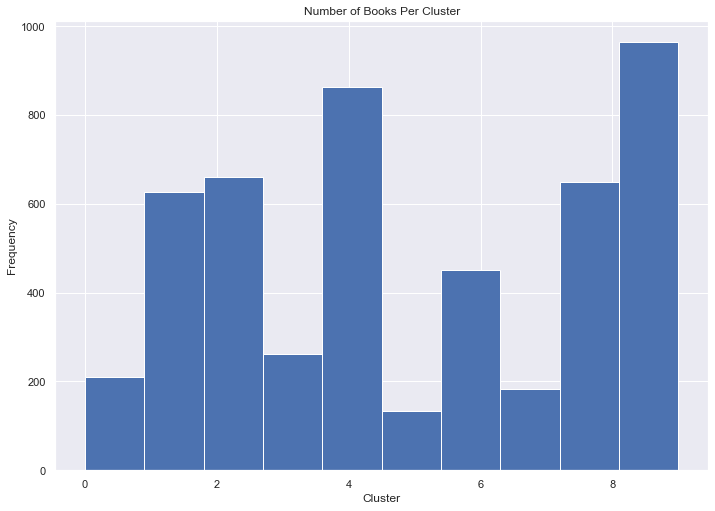

In [285]:
# Visualize Baseline Accuracy
model = KMeans (n_clusters=10, init='k-means++', random_state=10)
model.fit(X)
bkpx['cluster'] = model.predict(X)

x = pd.merge(bkpx, ub, how='inner', left_on='book_id', right_on='book_id')

print(x[:5000].groupby('cluster_x')['book_id'].count())
len(x[:5000][x[:5000]['cluster_x']==1])


plt.hist(x[:5000]['cluster_x'], bins=10, label=True)
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.title("Number of Books Per Cluster")